### Titanic Notebook

Data comes from the [kaggle](https://www.kaggle.com/competitions/titanic/) challenge to predict survival on the titanic.

The goal is to develop a model able to explain the chances of survival for any passenger. The format for this project is organized as a *kaggle competition*, providing a **train** and a **test** set. The latter does not contain the depedent variable and will be used for creating a submission file to the competition.


This notebook conducts an exploration of the dataset as well as a first attempt using ensemble models.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# training data
df = pd.read_csv('train.csv')
# test data for submission without outcome
df_test = pd.read_csv('test.csv')
assert df.shape[1] == df_test.shape[1] + 1
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [3]:
assert df_test.shape[0] == 418 # hence submission file will have 418 rows with 2 columns (ID + outcome)
df_test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


#### Data description


9 independent variables to predict survival + passenger id and name:


| Column    | Description                              | Values                                |
|-----------|------------------------------------------|---------------------------------------|
| survival  | Survival                                 | 0 = No, 1 = Yes                       |
| pclass    | Ticket class                             | 1 = 1st, 2 = 2nd, 3 = 3rd             |
| sex       | Sex                                      |                                       |
| Age       | Age in years                             |                                       |
| sibsp     | # of siblings / spouses aboard the Titanic |                                       |
| parch     | # of parents / children aboard the Titanic |                                       |
| ticket    | Ticket number                            |                                       |
| fare      | Passenger fare                           |                                       |
| cabin     | Cabin number                             |                                       |
| embarked  | Port of Embarkation                      | C = Cherbourg, Q = Queenstown, S = Southampton |


For *embarked* and *ticket* are likely independent of the outcome, they will be dropped. We also drop the name as *Age* and *sex* accounts for social factors such as being a child or being female ('Women and children first!').

Lastly, *passangerid* is assumed to be irrelevant, too.


In [4]:
df.drop(columns=['Embarked', 'Name', 'Ticket', 'PassengerId'], inplace=True)
df['Sex'] = df['Sex'].apply(lambda x: 1.0 if x == 'male' else 0.0)
print(df.isna().sum())

Survived      0
Pclass        0
Sex           0
Age         177
SibSp         0
Parch         0
Fare          0
Cabin       687
dtype: int64


In [5]:
687 / df.shape[0] # 0.7710437710437711 missing values in Cabin --> drop column
177 / df.shape[0] # 0.19865319865319866 missing values in Age --> handle missing values by filling them with the median

0.19865319865319866

In [6]:
df = df.drop(columns=['Cabin'])
df['Age'] = df['Age'].fillna(df['Age'].median())
assert df.isna().sum().all() == 0
df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare
0,0,3,1.0,22.0,1,0,7.2500
1,1,1,0.0,38.0,1,0,71.2833
2,1,3,0.0,26.0,0,0,7.9250
3,1,1,0.0,35.0,1,0,53.1000
4,0,3,1.0,35.0,0,0,8.0500


In [7]:
# apply same preprocessing to test data
df_test['Age'] = df['Age'].fillna(df['Age'].median())
df_test = df_test.drop(columns=['Embarked', 'Name', 'Ticket', 'PassengerId', 'Cabin'])
df_test['Sex'] = df_test['Sex'].apply(lambda x: 1.0 if x == 'male' else 0.0)

In [8]:
# hold 0.10% back for validation
from sklearn.model_selection import train_test_split

df_training, df_validation = train_test_split(df, test_size=0.10, random_state=42)
df_training_y, df_validation_y = df_training['Survived'], df_validation['Survived']

df_training.drop(columns=['Survived'], inplace=True)
df_validation.drop(columns=['Survived'], inplace=True)

#### Visualizations

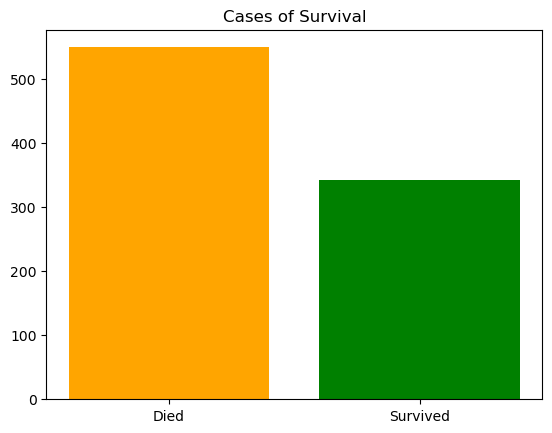

In [9]:
# rate of survival
df = pd.read_csv('train.csv')
plt.bar(['Died', 'Survived'], df['Survived'].value_counts(), color # assuming 0 means death
        =['orange', 'green']);
plt.title('Cases of Survival'); # note the missing data is held back for validation

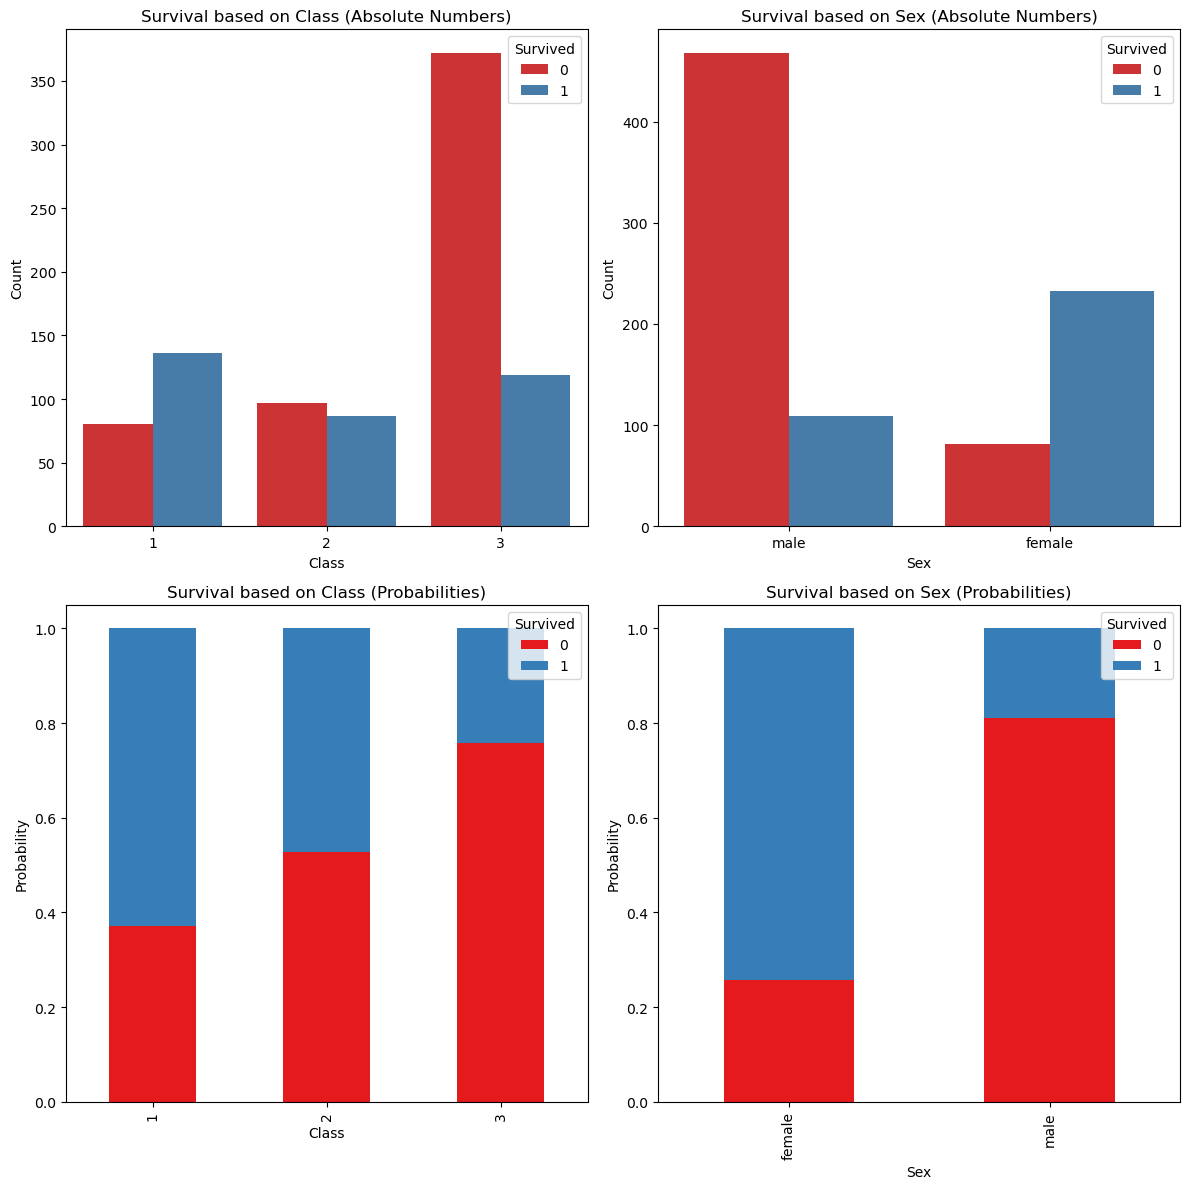

In [10]:
# survival rates based on groups

import seaborn as sns

plt.figure(figsize=(12, 12))

# Plot 1: Survival based on class (absolute numbers)
plt.subplot(2, 2, 1)
sns.countplot(x='Pclass', hue='Survived', data=df, palette='Set1')
plt.title('Survival based on Class (Absolute Numbers)')
plt.xlabel('Class')
plt.ylabel('Count')
plt.legend(title='Survived', loc='upper right')

# Plot 2: Survival based on sex (absolute numbers)
plt.subplot(2, 2, 2)
sns.countplot(x='Sex', hue='Survived', data=df, palette='Set1')
plt.title('Survival based on Sex (Absolute Numbers)')
plt.xlabel('Sex')
plt.ylabel('Count')
plt.legend(title='Survived', loc='upper right')

# Plot 3: Survival based on class (probabilities)
plt.subplot(2, 2, 3)
class_counts = df.groupby(['Pclass', 'Survived']).size().unstack().fillna(0)
class_probs = class_counts.div(class_counts.sum(axis=1), axis=0)
class_probs.plot(kind='bar', stacked=True, ax=plt.gca(), color=sns.color_palette('Set1',2))
plt.title('Survival based on Class (Probabilities)')
plt.xlabel('Class')
plt.ylabel('Probability')
plt.legend(title='Survived', loc='upper right')

# Plot 4: Survival based on sex (probabilities)
plt.subplot(2, 2, 4)
sex_counts = df.groupby(['Sex', 'Survived']).size().unstack().fillna(0)
sex_probs = sex_counts.div(sex_counts.sum(axis=1), axis=0)
sex_probs.plot(kind='bar', stacked=True, ax=plt.gca(), color=sns.color_palette('Set1'))
plt.title('Survival based on Sex (Probabilities)')
plt.xlabel('Sex')
plt.ylabel('Probability')
plt.legend(title='Survived', loc='upper right')

plt.tight_layout()
plt.show()

Text(0.5, 1.0, 'Family Size related to Survival')

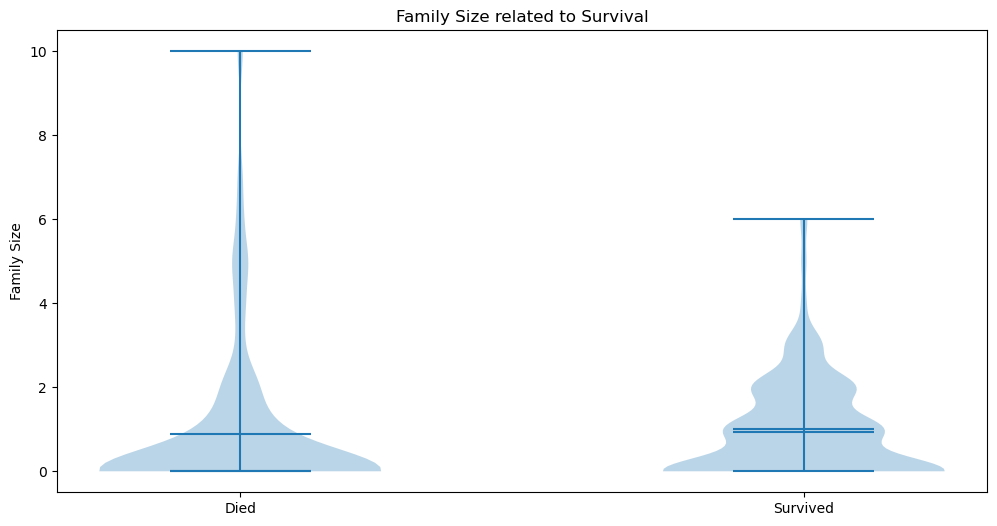

In [11]:
df['FamilySize'] = df['SibSp'] + df['Parch']

plt.figure(figsize=(12, 6))
plt.violinplot([df[df['Survived'] == 0]['FamilySize'], df[df['Survived'] == 1]['FamilySize']], showmeans=True, showmedians=True, showextrema=True)
plt.xticks([1, 2], ['Died', 'Survived'])
plt.ylabel('Family Size')
plt.title('Family Size related to Survival')

/var/folders/dj/bsr7j10j4lbgx87p46d9x1tc0000gn/T/ipykernel_68709/4256820689.py:11: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  age_survival = df.groupby(age_bins)['Survived'].mean()


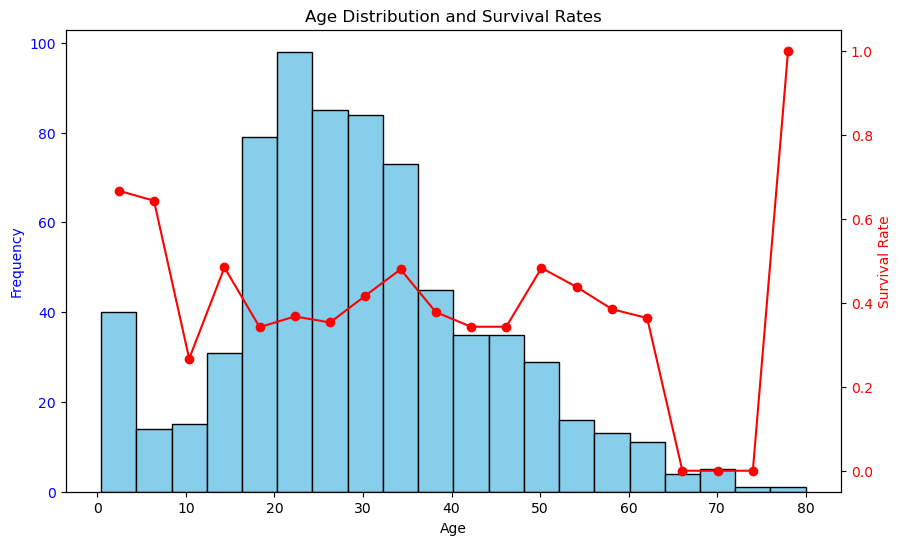

In [12]:
fig, ax1 = plt.subplots(figsize=(10, 6))

# Histogram of age distribution
n, bins, patches = ax1.hist(df['Age'], bins=20, color='skyblue', edgecolor='black')
ax1.set_xlabel('Age')
ax1.set_ylabel('Frequency', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

# Calculate survival rates based on age bins
age_bins = pd.cut(df['Age'], bins=bins)
age_survival = df.groupby(age_bins)['Survived'].mean()

# Output the calculated values for verification
#print("Bins:", bins)
#print("Age Bins:", age_bins)
#print("Survival Rates by Age Bins:", age_survival)

# Plot survival rates on the secondary y-axis
ax2 = ax1.twinx()
# Shift the bin edges slightly to the right
bin_centers = (bins[:-1] + bins[1:]) / 2
ax2.plot(bin_centers, age_survival, color='red', marker='o')
ax2.set_ylabel('Survival Rate', color='red')
ax2.tick_params(axis='y', labelcolor='red')

plt.title('Age Distribution and Survival Rates')
plt.show()

In [13]:
# this is correct
df[df['Age']>70]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,FamilySize
96,97,0,1,"Goldschmidt, Mr. George B",male,71.0,0,0,PC 17754,34.6542,A5,C,0
116,117,0,3,"Connors, Mr. Patrick",male,70.5,0,0,370369,7.7500,NaN,Q,0
493,494,0,1,"Artagaveytia, Mr. Ramon",male,71.0,0,0,PC 17609,49.5042,NaN,C,0
630,631,1,1,"Barkworth, Mr. Algernon Henry Wilson",male,80.0,0,0,27042,30.0000,A23,S,0
851,852,0,3,"Svensson, Mr. Johan",male,74.0,0,0,347060,7.7750,NaN,S,0


In [14]:
df['Title'] = df['Name'].apply(lambda x: x.split(',')[1].split('.')[0].strip())
df['Title'].value_counts()

Title
Mr              517
Miss            182
Mrs             125
Master           40
Dr                7
Rev               6
Mlle              2
Major             2
Col               2
the Countess      1
Capt              1
Ms                1
Sir               1
Lady              1
Mme               1
Don               1
Jonkheer          1
Name: count, dtype: int64

In [15]:
df['Title'] = df['Title'].replace(['Lady', 'the Countess', 'Countess', 'Capt', 'Col', 'Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Other')
df['Title'] = df['Title'].replace(['Mlle', 'Ms'], 'Miss')
df['Title'] = df['Title'].replace('Mme', 'Mrs')
df['Title'].value_counts()

Title
Mr        517
Miss      185
Mrs       126
Master     40
Other      23
Name: count, dtype: int64

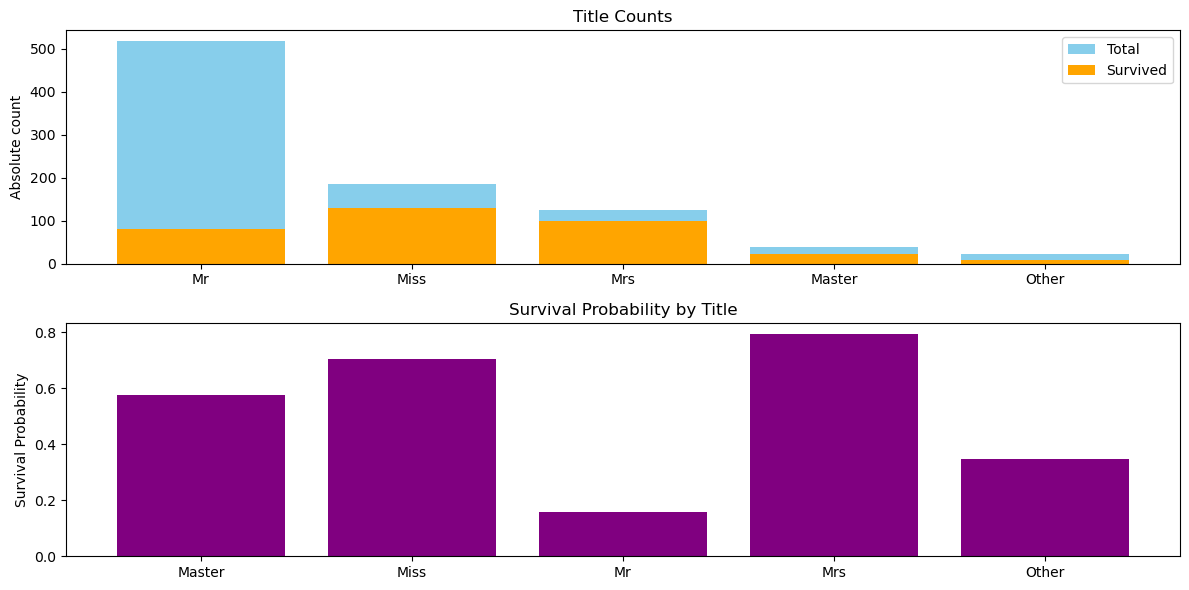

In [17]:
# First plot: Absolute counts
plt.figure(figsize=(12, 6))

plt.subplot(2, 1, 1)
plt.bar(df['Title'].value_counts().index, df['Title'].value_counts(), color='skyblue', label='Total')
plt.bar(df[df['Survived'] == 1]['Title'].value_counts().index, df[df['Survived'] == 1]['Title'].value_counts(), color='orange', label='Survived')
plt.ylabel('Absolute count')
plt.title('Title Counts')
plt.legend()

# Second plot: Probabilities
plt.subplot(2, 1, 2)
title_counts = df['Title'].value_counts()
survived_counts = df[df['Survived'] == 1]['Title'].value_counts()
survival_probabilities = survived_counts / title_counts

plt.bar(survival_probabilities.index, survival_probabilities, color='purple')
plt.ylabel('Survival Probability')
plt.title('Survival Probability by Title')

plt.tight_layout()
plt.show()

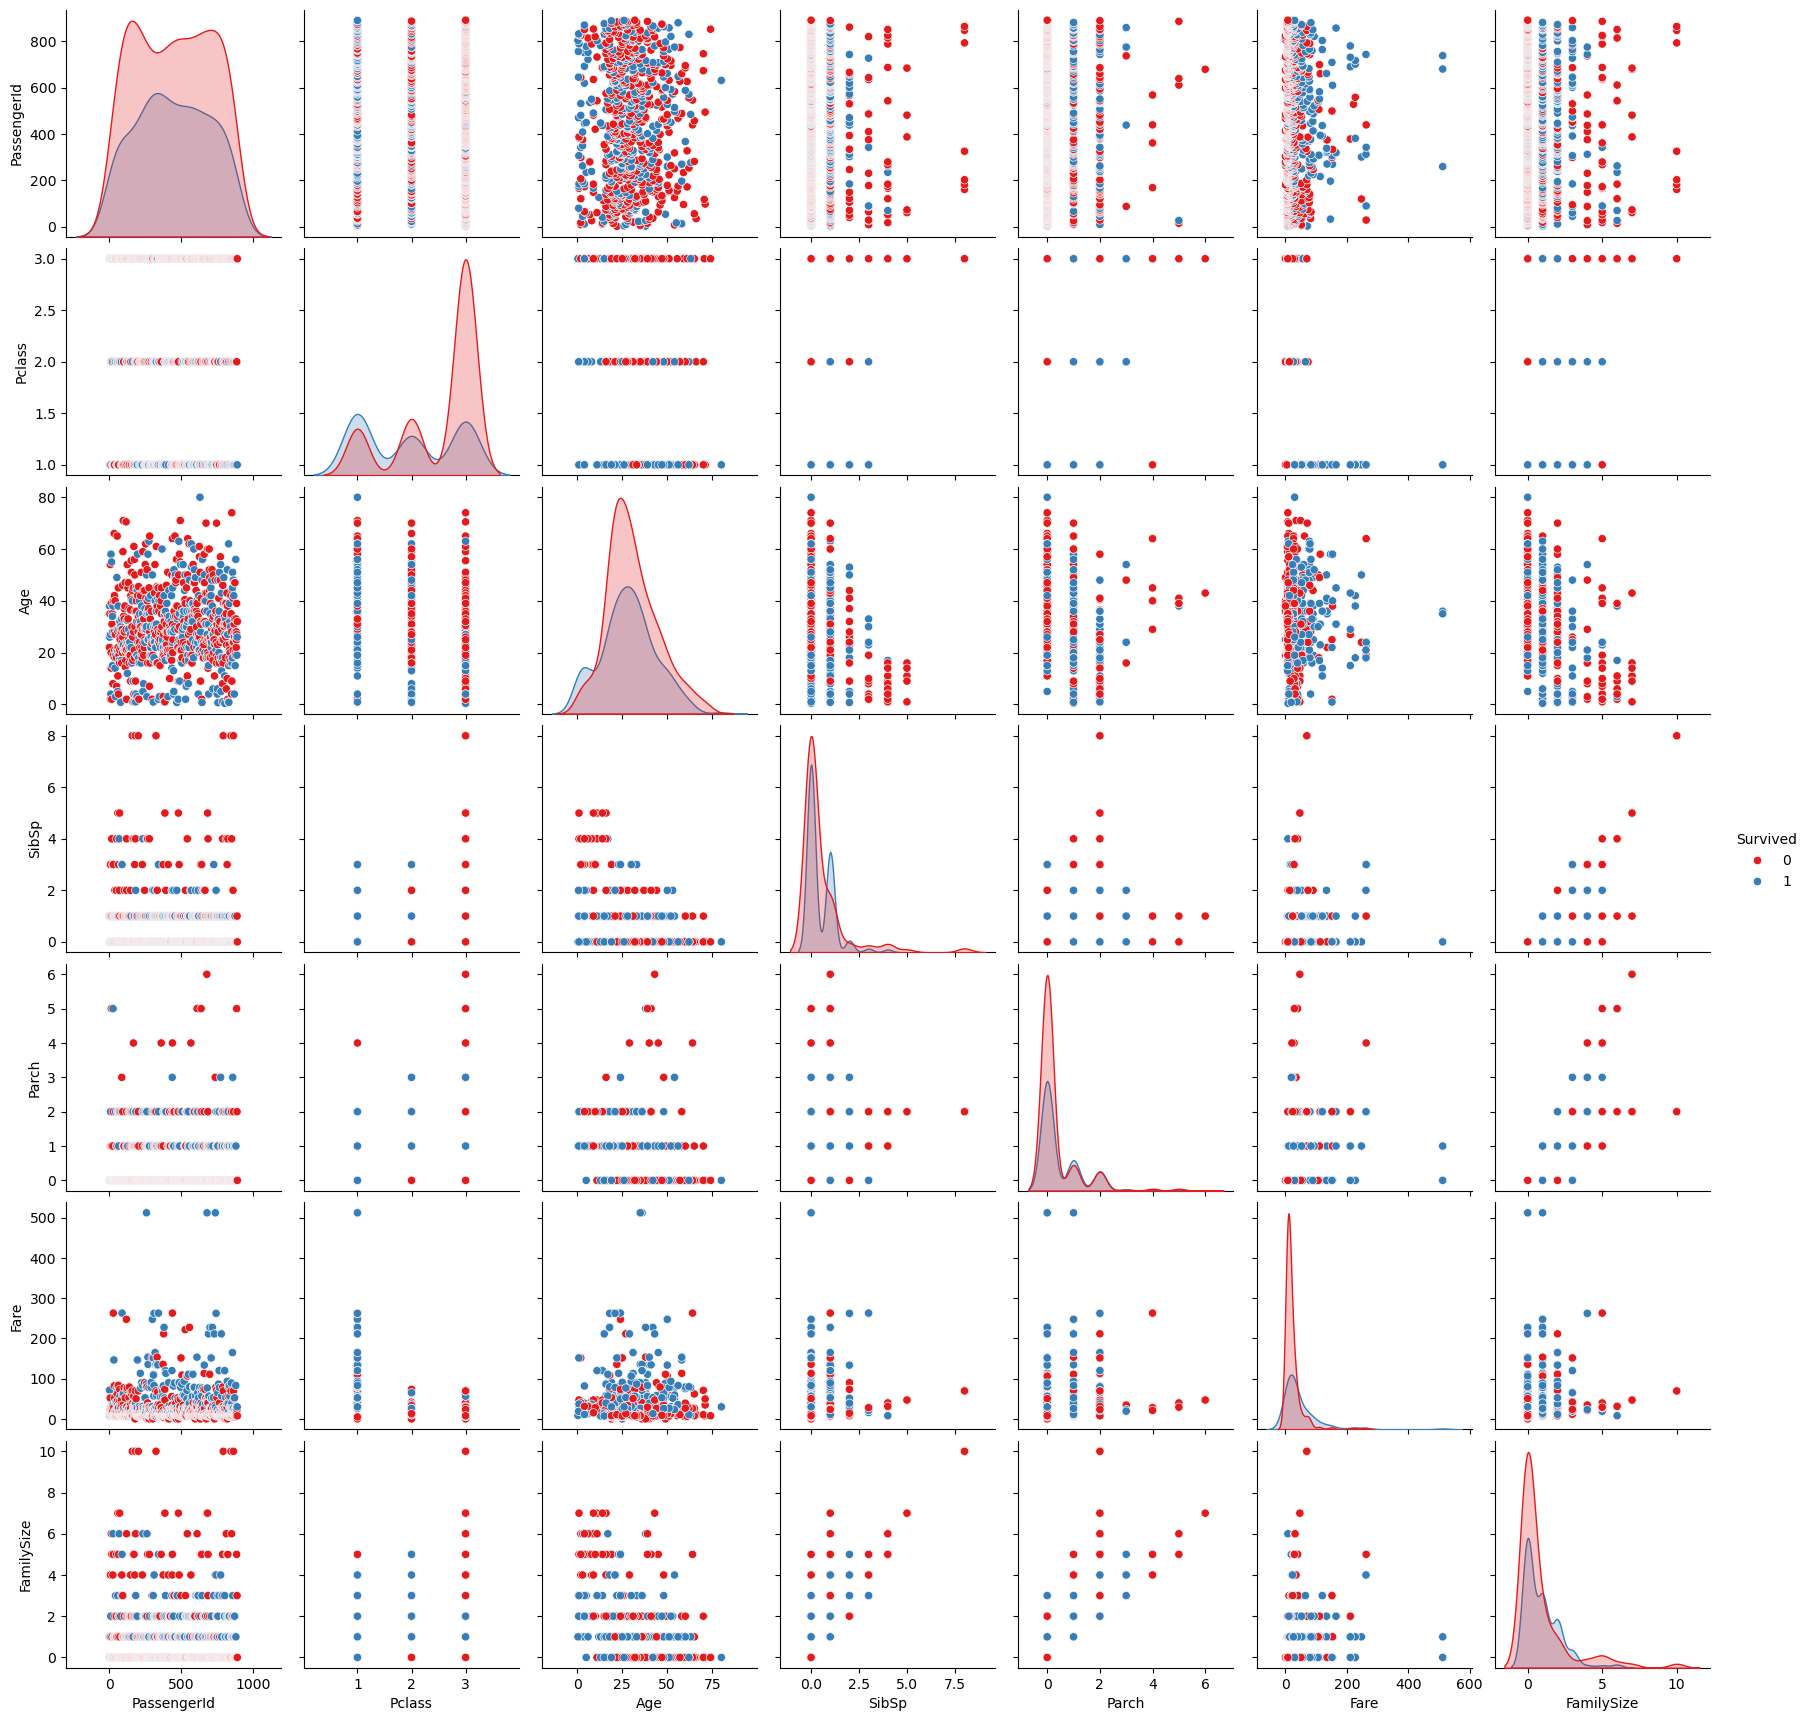

In [18]:
# for the enthusisast
sns.pairplot(df, hue='Survived', palette='Set1')

#### Ensemble models

In [19]:
# train a model
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score


model = GradientBoostingClassifier(n_estimators=100, random_state=42)
model.fit(df_training, df_training_y)
preds = model.predict(df_validation)
gbm_accuracy_score = accuracy_score(df_validation_y, preds)


model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(df_training, df_training_y)
preds = model.predict(df_validation)
rfr_accuracy_score = accuracy_score(df_validation_y, preds)

print(gbm_accuracy_score, rfr_accuracy_score)


0.8333333333333334 0.8222222222222222


In [ ]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV

# Define parameter grids
gbm_param_grid = {
    'n_estimators': [50, 100, 150],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 4, 5],
    'subsample': [0.5, 0.75, 1.0],
    'min_samples_leaf': [1, 2, 3]
}

rfr_param_grid = {
    'n_estimators': [50, 100, 150],
    'max_depth': [None, 5, 10, 20],
    'min_samples_split': [2, 5, 10], 
    'criterion': ['gini', 'entropy', 'log_loss'],
    'max_leaf_nodes': [None, 5, 10, 20],
    'class_weight': ['balanced', 'balanced_subsample', None]
    
}

# Grid search for GradientBoostingClassifier
gbm_grid_search = GridSearchCV(GradientBoostingClassifier(random_state=42), gbm_param_grid, cv=5, scoring='accuracy')
gbm_grid_search.fit(df_training, df_training_y)
gbm_best_model = gbm_grid_search.best_estimator_
gbm_preds = gbm_best_model.predict(df_validation)
gbm_accuracy_score = accuracy_score(df_validation_y, gbm_preds)

# Grid search for RandomForestClassifier
rfr_grid_search = GridSearchCV(RandomForestClassifier(random_state=42), rfr_param_grid, cv=5, scoring='accuracy')
rfr_grid_search.fit(df_training, df_training_y)
rfr_best_model = rfr_grid_search.best_estimator_
rfr_preds = rfr_best_model.predict(df_validation)
rfr_accuracy_score = accuracy_score(df_validation_y, rfr_preds)

print(gbm_accuracy_score, rfr_accuracy_score)

In [14]:
from sklearn.model_selection import LeaveOneOut
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV


loo = LeaveOneOut()
accuracies = []

df_training_full = df.copy()
df_training_full_y = df_training_full['Survived']
df_training_full.drop(columns=['Survived'], inplace=True)

for train_index, test_index in loo.split(df_training_full):
    X_train, X_test = df_training_full.iloc[train_index], df_training_full.iloc[test_index]
    y_train, y_test = df_training_full_y.iloc[train_index], df_training_full_y.iloc[test_index]
    
    model = gbm_best_model
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracies.append(accuracy_score(y_test, y_pred))

mean_accuracy = np.mean(accuracies)
print(f'Mean accuracy from N-1 CV: {mean_accuracy}')

Mean accuracy from N-1 CV: 0.8395061728395061


In [ ]:
from sklearn.model_selection import LeaveOneOut
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV

In [39]:
# XGBoost
import xgboost as xgb
from sklearn.metrics import accuracy_score

# Initialize the XGBoost classifier. Strategy: play with the parameters or use grid search as above
xgb_model = xgb.XGBClassifier(n_estimators=15, random_state=42, max_depth=5, objective='binary:logistic')

# Train the model
xgb_model.fit(df_training, df_training_y)

# Make predictions
preds = xgb_model.predict(df_validation)

# Evaluate the model
accuracy = accuracy_score(df_validation_y, preds)
print(f'Accuracy: {accuracy}')


Accuracy: 0.8444444444444444


In [16]:
# grid search for XGBoost

xgb_param_grid = {
    'n_estimators': [50, 100, 150],
    'max_depth': [None, 5, 10, 20],
    #'min_child_weight': [1, 3, 5],  # Equivalent to min_samples_split in XGBoost
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.6, 0.8, 1.0],
    'objective': ['binary:logistic'],
    #'colsample_bytree': [0.6, 0.8, 1.0],
    #'gamma': [0, 0.1, 0.2],
    #'reg_alpha': [0, 0.1, 1],
    #'reg_lambda': [1, 1.5, 2]
}

# Perform grid search
xgb_grid_search = GridSearchCV(xgb.XGBClassifier(random_state=42), xgb_param_grid, cv=5, scoring='accuracy')
xgb_grid_search.fit(df_training, df_training_y)
xgb_best_model = xgb_grid_search.best_estimator_
xgb_preds = xgb_best_model.predict(df_validation)
xgb_accuracy_score = accuracy_score(df_validation_y, xgb_preds)

print(f'Best Parameters: {xgb_grid_search.best_params_}')
print(f'Validation Accuracy: {xgb_accuracy_score}')

xgboost_best_model = xgb_grid_search.best_estimator_

# N-1 CV
accuracies = []
loo = LeaveOneOut()

df_training_full = df.copy()
df_training_full_y = df_training_full['Survived']
df_training_full.drop(columns=['Survived'], inplace=True)

for train_index, test_index in loo.split(df_training_full):
    X_train, X_test = df_training_full.iloc[train_index], df_training_full.iloc[test_index]
    y_train, y_test = df_training_full_y.iloc[train_index], df_training_full_y.iloc[test_index]
    
    xgb_model = xgboost_best_model
    xgb_model.fit(X_train, y_train)
    y_pred = xgb_model.predict(X_test)
    accuracies.append(accuracy_score(y_test, y_pred))

mean_accuracy = np.mean(accuracies)
print(f'Mean accuracy from N-1 CV: {mean_accuracy}')

Best Parameters: {'learning_rate': 0.1, 'max_depth': None, 'n_estimators': 100, 'objective': 'binary:logistic', 'subsample': 1.0}
Validation Accuracy: 0.8222222222222222
Mean accuracy from N-1 CV: 0.8305274971941639


In [47]:
# make preds for submission file
xgb_preds = xgb_model.predict(df_test)

df_test = pd.read_csv('test.csv')
df_sub = pd.DataFrame({'PassengerId': df_test['PassengerId'], 'Survived': xgb_preds})
df_sub.to_csv('titanic_xgboost_submission.csv', index=False)
df_sub.head()

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,0


In [26]:
import gc
gc.collect()

%reset -f

#### FFN  

In [3]:
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
import tensorflow as tf
from keras.optimizers import Adam, SGD
from keras.models import Sequential 
from keras.layers import Dense, Dropout, Input

In [60]:
# Enable GPU support for Apple M2
physical_devices = tf.config.list_physical_devices('GPU')
if len(physical_devices) > 0:
    print("GPU is available and enabled.")
else:
    print("GPU is not available.")

# set up n fold cv
n_folds = 5
X = df_training
y = df_training_y

optimizer = Adam()

def create_model(n_inputs):
    model = Sequential()
    model.add(Input(shape=(n_inputs,)))
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(0.1))
    model.add(Dense(16, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

kf = KFold(n_splits=n_folds, shuffle=True, random_state=42)
fold_acc = []
model = create_model(X_train.shape[1])

# train loop
for train_index, test_index in kf.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    model.fit(X_train, y_train, epochs=100, batch_size=16, verbose=0)
    _, accuracy = model.evaluate(X_test, y_test)
    fold_acc.append(accuracy)
    
# evaluate
val_preds = model.predict(df_validation)
val_preds = (val_preds > 0.5).astype(int)
val_accuracy = accuracy_score(df_validation_y, val_preds)

print(f'{n_folds}-fold CV Accuracies: {fold_acc}')
print(f'Validation Accuracy: {round(val_accuracy, 3)}')

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.7712 - loss: 0.4339
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7706 - loss: 0.5315 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8324 - loss: 0.4255 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8280 - loss: 0.4293 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8426 - loss: 0.3733 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
5-fold CV Accuracies: [0.7763975262641907, 0.800000011920929, 0.8187500238418579, 0.824999988079071, 0.800000011920929]
Validation Accuracy: 0.767


In [ ]:
# leave one out classification
from sklearn.model_selection import LeaveOneOut

loo = LeaveOneOut()

df_training_full = df.copy()
df_training_full_y = df_training_full['Survived']
df_training_full = df_training_full.drop(columns=['Survived'])

acc = []

for train_index, test_index in loo.split(df_training_full):
    X_train, X_test = df_training_full.iloc[train_index], df_training_full.iloc[test_index]
    y_train, y_test = df_training_full_y.iloc[train_index], df_training_full_y.iloc[test_index]
    
    model.fit(X_train, y_train, epochs=100, batch_size=16, verbose=0)
    preds = model.predict(X_test)
    ac = accuracy_score(y_test, (preds > 0.5).astype(int))
    acc.append(ac)
    
mean_accuracy = np.mean(acc)
print(f'Mean accuracy from N-1 CV: {mean_accuracy}')

In [ ]:
import gc
gc.collect()

%reset -f

#### Support Vector Machine



In [72]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

# Initialize the SVC model
model = SVC(kernel='linear', C=1.0, random_state=42, probability=True, shrinking=False, gamma='auto')

# Initialize GridSearchCV

# Assuming X_train and y_train are your training data and labels
model.fit(df_training, df_training_y)


preds = model.predict(df_validation)
print(f"Accuracy on validation set: {accuracy_score(df_validation_y, preds)}")


Accuracy on validation set: 0.8111111111111111
